Generates tiles using a given grid for a set of rasters generated per-catchment

In [12]:
%matplotlib inline

from pykml import parser
import shapely.geometry, shapely.wkt
from shapely.geometry.polygon import LinearRing
from shapely.geometry.polygon import Polygon
import shapely as sl
import fiona
import numpy as np

import matplotlib.pyplot as plt
import pylab

from utils.shapely_plot import draw

pylab.rcParams['figure.figsize'] = (17.0, 15.0)

In [13]:
# read grid cells

doc = file("../data/grid.kml").read()

root = parser.fromstring(doc)

placemarks = [c for c in root.Document.Placemark]

def get_feature(placemark):
    data = placemark.ExtendedData.Data
    id = int([d.value for d in placemark.ExtendedData.Data if d.get('name') == 'id'][0])

    scoords = str([d for d in placemark.Polygon.outerBoundaryIs.LinearRing.coordinates][0])[:-1]
    coords = [(float(c[0]), float(c[1])) for c in [p.split(',') for p in scoords.split(' ')]]
    geom = Polygon(LinearRing(coords))
    
    return (id, geom)    

In [14]:
cells = [get_feature(placemark) for placemark in placemarks]

1964


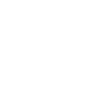

In [15]:
cell50 = cells[50]

# de
print(cell50[0])
cell50[1]

In [16]:
g = cell50[1]

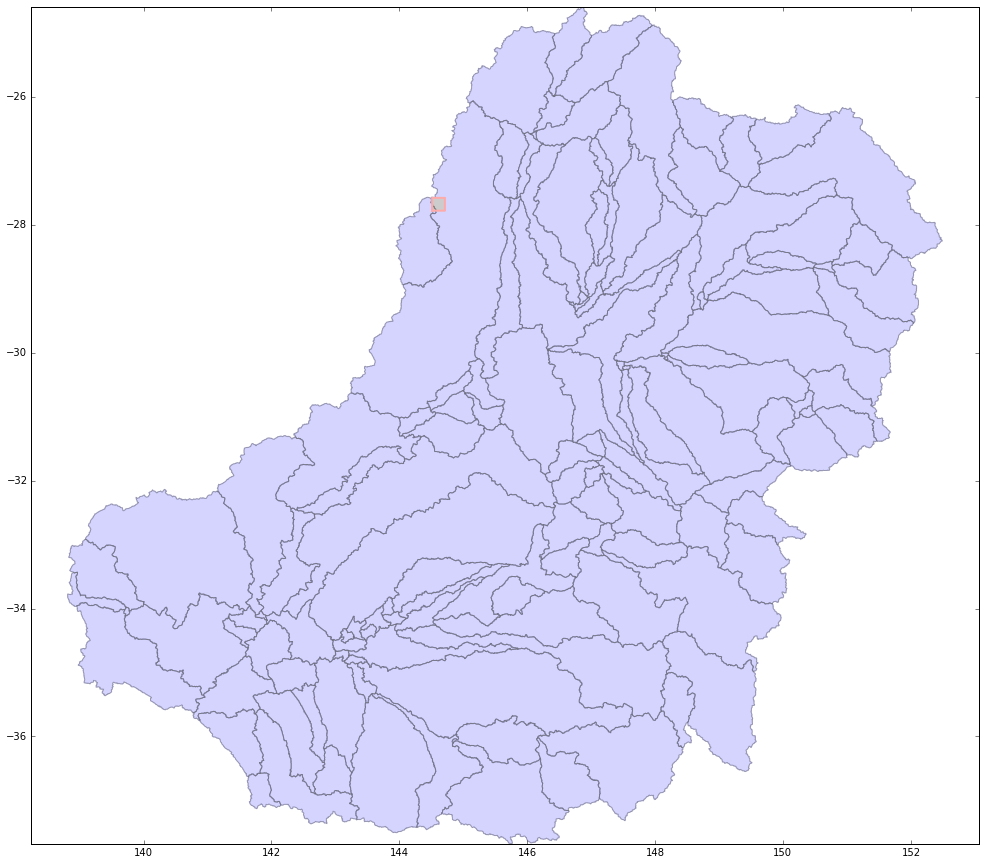

In [6]:
# read catchments

catchments_path = r'../data/HydroBASINS/without_lakes/hybas_au_lev06_v1c.shp'

fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

bounds = (138.8119327121311, -37.679166666666646, 152.4875, -24.591666666666637)
axes.set_xlim(bounds[0], bounds[2])
axes.set_ylim(bounds[1], bounds[3])

with fiona.collection(catchments_path, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])
        pfaf_id = int(f['properties']['PFAF_ID'])
        
        if pfaf_id >= 564000 and pfaf_id <= 564999:
            draw(geom, fill='#aaaaff', alpha=0.5)
            
draw(cell50[1], outline='#ffaaaa', lw=2.0)            

plt.show()  


5060073410


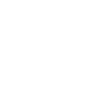

In [7]:
catchments = []
with fiona.collection(catchments_path, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])
        pfaf_id = int(f['properties']['PFAF_ID'])
        id = int(f['properties']['HYBAS_ID'])
        
        if pfaf_id >= 564000 and pfaf_id <= 564999:
            catchments.append((id, geom))

print(catchments[0][0])
catchments[0][1]

* convert all catchments to shp files id_catchment.shp
* convert all grid cells to shp files id_cell.shp

* foreach grid cell:
    * find overlapping catchments
	* foreach overlapping raster
		* clip raster by its catchment:
	* merge all overlapping and clipped rasters

In [8]:
from shapely.geometry import mapping
import fiona
import subprocess
import os

def remove_file(path):
    if os.path.exists(path):
        os.remove(path)

def clip_catchment_by_cell(cell_geom, catchment_geom):
    return cell_geom.intersection(catchment_geom)

def write_shp(geom, shp_path, id):
    schema = { 'geometry': 'Polygon', 'properties': {'id': 'int'}, }

    with fiona.open(shp_path, 'w', 'ESRI Shapefile', schema) as c:
        c.write({'geometry': mapping(geom), 'properties': {'id': id}})

def clip_raster(in_path, out_path, shp_path):
    cmd = u'gdalwarp -dstnodata -99999 -q -cutline {0} -crop_to_cutline -of GTiff {1} {2}'.format(shp_path, in_path, out_path)
    subprocess.check_call(cmd, shell=True)
    pass

def merge_rasters(in_paths, out_path):
    # merge_cmd = r'python C:\OSGeo4W32\bin\gdal_merge.py'
    merge_cmd = r'gdal_merge.py'
    cmd = merge_cmd + u'  -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=6 -n -99999 -a_nodata -99999 -of GTiff -o {0} {1}'.format(out_path, in_paths)
    subprocess.check_call(cmd, shell=True)
    pass

def generate_tile_raster(cell, catchments, catchment_raster_format, cell_raster_format, temp_dir):
    # print('Merging sub-catchments raster for cell {0}: '.format(cell[0]))
          
    cell_id = cell[0]
    cell_geom = cell[1]
    
    out_catchment_rasters = []
    for (idx, catchment) in enumerate(cell_catchments):
        catchment_id = catchment[0]
        catchment_geom = catchment[1]

        # write (catchment x cell) to Shapefile
        g = clip_catchment_by_cell(cell_geom, catchment_geom)
        
        if g.area < 1e-5:
            continue
        
        clip_shp = temp_dir + str(idx) + '.shp'
        write_shp(g, clip_shp, idx)
        
        # clip catchment raster by the polygon from previous step
        in_catchment_raster = catchment_raster_format.format(catchment_id)
        out_catchment_raster = temp_dir + str(idx) + '.tif'
        
        # print('Clipping ' + in_catchment_raster + ' ...')
        clip_raster(in_catchment_raster, out_catchment_raster, clip_shp)

        out_catchment_rasters.append(out_catchment_raster)

        # clean-up
        remove_file(temp_dir + str(idx) + '.cpg')
        remove_file(temp_dir + str(idx) + '.dbf')
        remove_file(temp_dir + str(idx) + '.shp')
        remove_file(temp_dir + str(idx) + '.shx')

    if len(out_catchment_rasters) == 0:
        return
        
    # merge sub-catchment rasters clipped by intersection of (cell x catchment)
    tile_path = cell_raster_format.format('{0:05}'.format(cell_id))
    # print('Genereting tile raster ' + tile_path + ' ...')
    merge_rasters(' '.join(out_catchment_rasters), tile_path)
    
    # clean-up
    for path in out_catchment_rasters:
        remove_file(path)

In [ ]:
def get_overlapping_catchments(g):
    for catchment in catchments:
        id = catchment[0]
        geom = catchment[1]
        if geom.intersects(g):
            yield (id, geom)
    

# find overlapping catchments for every cell and clip+merge corresponding rasters
idx = 0
for cell in cells[idx:]:
    cell_id = cell[0]
    cell_geom = cell[1]
    cell_catchments = list(get_overlapping_catchments(cell_geom))
    
    print('cell: {0}, id: {1}, catchment_count: {2}'.format(idx, cell_id, len(cell_catchments)))
        
    generate_tile_raster(cell, cell_catchments, 
        '../output_lddout/SRTM_30_Murray_Darling_{0}_hand.tif', 
        '../output_lddout_tiled/SRTM_30_Murray_Darling_cell_{0}_hand.tif', 
        r'../temp/')
    
    idx = idx + 1


cell: 0, id: 2240, catchment_count: 1
cell: 1, id: 2239, catchment_count: 1
cell: 2, id: 2173, catchment_count: 1
cell: 3, id: 2238, catchment_count: 1
cell: 4, id: 2172, catchment_count: 1
cell: 5, id: 2237, catchment_count: 1
cell: 6, id: 2236, catchment_count: 1
cell: 7, id: 2170, catchment_count: 2
cell: 8, id: 2171, catchment_count: 1
cell: 9, id: 2105, catchment_count: 1
cell: 10, id: 2103, catchment_count: 1
cell: 11, id: 2104, catchment_count: 2
cell: 12, id: 2169, catchment_count: 2
cell: 13, id: 2235, catchment_count: 2
cell: 14, id: 2234, catchment_count: 1
cell: 15, id: 2233, catchment_count: 2
cell: 16, id: 2167, catchment_count: 1
cell: 17, id: 2168, catchment_count: 1
cell: 18, id: 2102, catchment_count: 1
cell: 19, id: 2101, catchment_count: 1
cell: 20, id: 2035, catchment_count: 1
cell: 21, id: 2036, catchment_count: 1
cell: 22, id: 2037, catchment_count: 1
cell: 23, id: 1966, catchment_count: 1
cell: 24, id: 1967, catchment_count: 1
cell: 25, id: 1968, catchment_count